## Results Processing

In [21]:
import os 
from dotenv import dotenv_values
import pandas as pd
from langfuse import Langfuse
import numpy as np
import ast  
langfuse = Langfuse()

In [19]:
for i,v in dotenv_values().items():
    globals()[i]=v 

RESULTS_FOLDER = os.path.join(PROJECT_DIR, "results")

In [20]:
def langfuse_run_ids(dataset_name, dataset_run_name):
    dataset_run = langfuse.get_dataset_run(
    dataset_name=dataset_name, dataset_run_name=dataset_run_name
    )
    trace_ids = [run_item.trace_id for run_item in dataset_run.dataset_run_items]
    return trace_ids

In [11]:
def open_results(dataset):
    return pd.read_csv(os.path.join(RESULTS_FOLDER, dataset))

In [12]:
def parse_cell(cell):
    if isinstance(cell, str) and cell.startswith('[') and cell.endswith(']'):
        try:
            value = ast.literal_eval(cell)
            return value[0] if isinstance(value, list) and len(value) == 1 else np.nan
        except:
            return np.nan
    return cell

In [16]:
def get_results(dataset):
    columns=['precision', 'recall', 'f1', 'semantic similarity', 'jaccard_similarity', 'r_precision', 'r_recall']
    dataset[columns] = dataset[columns].fillna(0).applymap(parse_cell)
    df = dataset[columns].copy()
    metrics = df.mean(skipna=True).to_dict()
    metrics['hallucinations'] = df[df['semantic similarity'] == -1].shape[0]
    return metrics

In [25]:
trace_ids = langfuse_run_ids("RAGHPO", "llama3.1:8b")
results = open_results("11052025.csv")
results = results[results.id.isin(trace_ids)]

In [26]:
results[['latency', 'inputCost', 'outputCost', 'totalCost']].mean()

latency       380.078026
inputCost            NaN
outputCost           NaN
totalCost            NaN
dtype: float64

In [ ]:
get_results(results)

{'precision': 0.4440301443302799,
 'recall': 0.27914775377624856,
 'f1': 0.3268376068376068,
 'semantic similarity': 0.18988064000509922,
 'jaccard_similarity': 0.20513861067773,
 'r_precision': 0.1686818266640675,
 'r_recall': 0.4000893687188765,
 'hallucinations': 13}

: 

<Axes: >

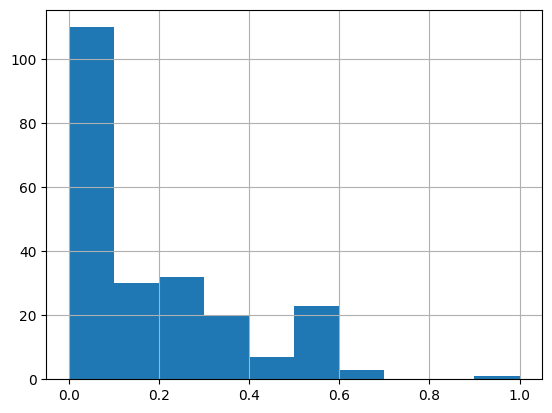

In [72]:
results.precision.hist()

In [ ]:
from scipy.stats import wilcoxon

stat, p_value = wilcoxon(results.precision.hist(), v2)
print(f"Wilcoxon = {stat}, p = {p_value}")
